In [114]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath(os.path.join("..", "src")))

df = pd.read_csv('../Data/Processed/hotel_clean4.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          29999 non-null  int64  
 1   no_of_children                        29999 non-null  int64  
 2   no_of_weekend_nights                  29999 non-null  int64  
 3   no_of_week_nights                     29999 non-null  int64  
 4   required_car_parking_space            29999 non-null  int64  
 5   lead_time                             29999 non-null  int64  
 6   arrival_year                          29999 non-null  int64  
 7   arrival_month                         29999 non-null  int64  
 8   arrival_date                          29999 non-null  int64  
 9   repeated_guest                        29999 non-null  int64  
 10  no_of_previous_cancellations          29999 non-null  int64  
 11  no_of_previous_

In [115]:

from sklearn.model_selection import train_test_split

# critères de base
features = [
    'no_of_special_requests', 'price_per_person',
    'required_car_parking_space', 'total_nights', 'total_people',
    'room_type_reserved', 'repeated_guest', 'no_of_previous_cancellations',
    'meal_plan_selected', 'avg_price_per_room',
    'market_segment_type_Online', 'is_family', 'stay_duration_flag', 'lead_time_category_181j+', 'lead_time_category_91-180j','lead_time_category_31-90j', 'lead_time_category_8-30j'
]
x = df[features]
# Critère à prédire
y = df['booking_status_Not_Canceled']


In [116]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1. Définir la grille d'hyperparamètres
param_dist_fine = {
    'n_estimators': np.arange(150, 301, 25),           # de 150 à 300 par pas de 25
    'max_depth': [10, 12, 14, 15, 16, 18, None],       # plusieurs profondeurs + None
    'min_samples_split': [2, 3, 4, 5],                  # splits plus fins
    'min_samples_leaf': [1, 2, 3],                      # minimum d'échantillons par feuille
    'max_features': ['sqrt', 'log2', None],             # essayer aussi None (toutes features)
    'bootstrap': [True, False]                           # test avec et sans bootstrap
}

# 2. Création du modèle de base
rf = RandomForestClassifier(random_state=42)

# 3. RandomizedSearchCV
random_search_fine = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_fine,
    n_iter=30,            # plus d’itérations pour plus de chance de trouver un bon combo
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. Entraînement
random_search_fine.fit(x_train, y_train)

# 5. Meilleur modèle
best_rf = random_search.best_estimator_
print('Random Forest Classifier:')
print("Meilleurs hyperparamètres :", random_search_fine.best_params_)
best_rf = random_search_fine.best_estimator_

# 6. Prédictions
y_probs = best_rf.predict_proba(x_test)[:, 1]
optimal_threshold = 0.6221
y_pred_thresh = (y_probs >= optimal_threshold).astype(int) # Seuillage optionnel
y_pred = best_rf.predict(x_test)

# 7. Évaluation
print("Accuracy sur les données de test : ", np.round(best_rf.score(x_test, y_test), 2)) # 0.88
print("Score moyen par validation croisée : ",
      np.round(np.mean(cross_val_score(best_rf, x, y, cv=5)), 2)) # 0.88
print("Précision : ", np.round(precision_score(y_test, y_pred_thresh), 2)) # 0.89
print("Rappel : ", np.round(recall_score(y_test, y_pred_thresh), 2)) # 0.94
print("Erreur quadratique moyenne : ", np.round(mean_squared_error(y_test, y_pred_thresh), 4)) # 0.1164
print("Accuracy (via accuracy_score) : ", np.round(accuracy_score(y_test, y_pred_thresh), 4)) # 0.8836

# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred_thresh)
print("Matrice de confusion :\n", cm)
#    [[1560  454]
#    [ 234 3661]]

# 9. Importance des variables
importances = best_rf.feature_importances_
features = x_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Importance des variables (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


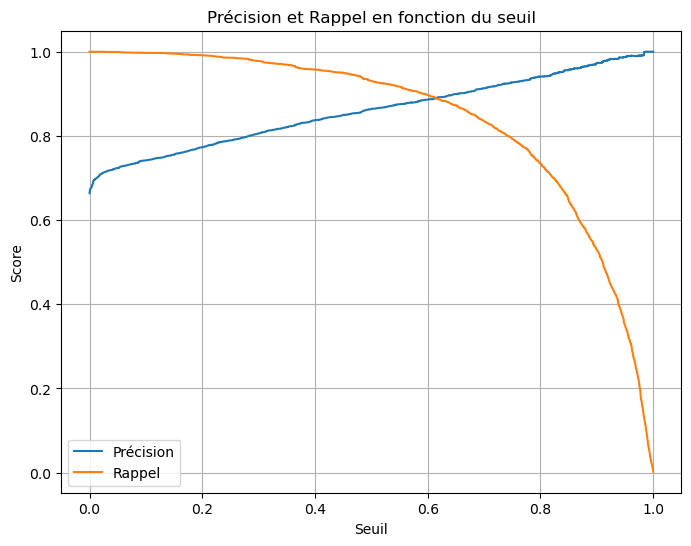

In [122]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(thresholds_pr, precisions[:-1], label='Précision')
plt.plot(thresholds_pr, recalls[:-1], label='Rappel')
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("Précision et Rappel en fonction du seuil")
plt.legend()
plt.grid()
plt.show()


AUC: 0.9221


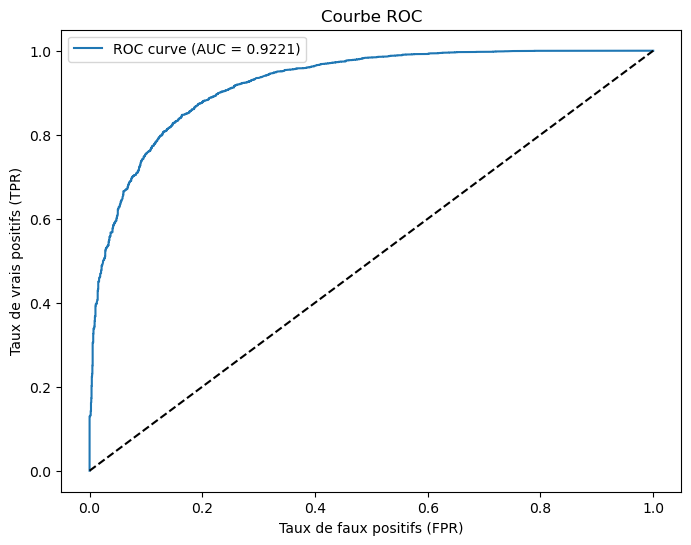

Seuil optimal pour la classification : 0.6869


In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np


y_probs = best_rf.predict_proba(x_test)[:, 1]

# Calculer les valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculer l'AUC
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc_score:.4f}")

# Tracer la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonale au hasard
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Trouver le seuil optimal : minimiser la distance à (0,1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

print(f"Seuil optimal pour la classification : {optimal_threshold:.4f}")

# Optionnel : appliquer ce seuil pour prédire
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


📷 Graphique sauvegardé dans : rfr_predict_errorRandomForest.png


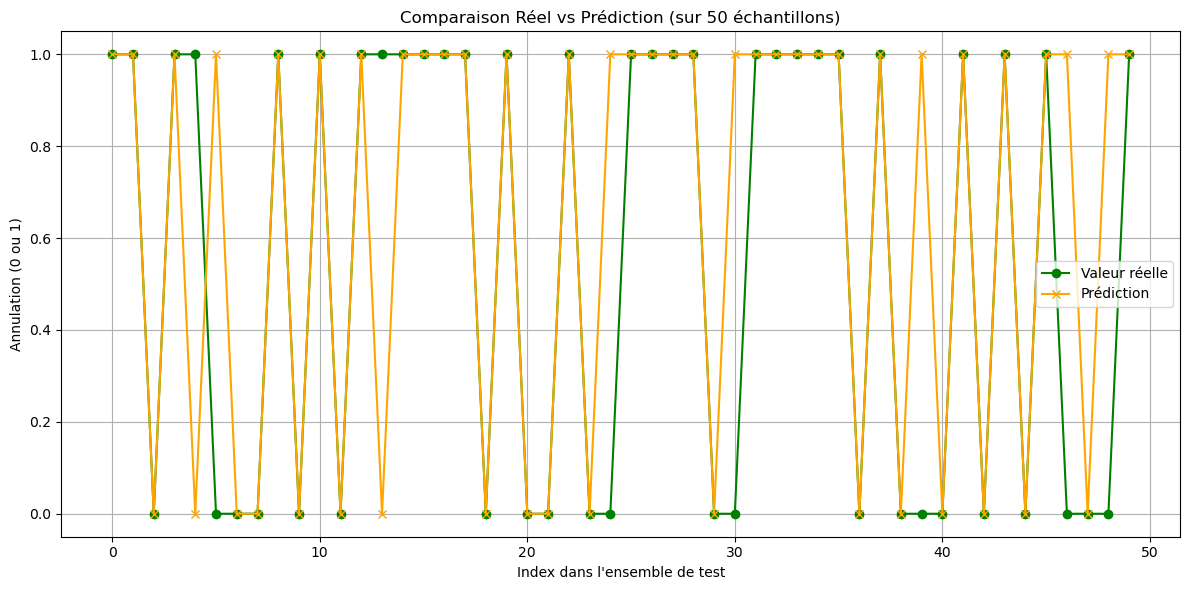

In [120]:
from graph_utils import display_predict_diff_errors2
display_predict_diff_errors2(y_test, predictions_reset, n=50, save_path="rfr_predict_errorRandomForest.png")